# Diffusion properties

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections
import os
import sys
sys.path.append("../")

from scipy import stats
from scipy.linalg import norm
from scipy.optimize import curve_fit

from config import results_folder, plots_folder, init_folder

In [2]:
plt.style.use('bmh')
%matplotlib inline
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 4
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

## Utility functions

In [3]:
def msd_function(t, v0, q, gamma):
    #v0 = 0.2
    return (v0**2-q/gamma)*(1-np.exp(-gamma*t))**2/gamma**2+2*q*t/gamma**2-2*q*(1-np.exp(-gamma*t))/gamma**3

def msd_function_v0(t, q, gamma):
    v0 = 0.2
    #v0 = 0.1784
    return (v0**2-q/gamma)*(1-np.exp(-gamma*t))**2/gamma**2+2*q*t/gamma**2-2*q*(1-np.exp(-gamma*t))/gamma**3

def msd_function_v0_higher_mass(t, q, gamma):
    v0 = 0.2
    v0 /= np.sqrt(3)
    return (v0**2-q/gamma)*(1-np.exp(-gamma*t))**2/gamma**2+2*q*t/gamma**2-2*q*(1-np.exp(-gamma*t))/gamma**3

In [4]:
def lin_fit(times, values, value_start):
    lin_fit_times = times[value_start:]
    lin_fit_values = values[value_start:]
    slope, intercept, r_value, p_value, std_err = stats.linregress(lin_fit_times, lin_fit_values)
    return slope, intercept

def adjust_curve(times, values, msd_func):
    popt, pcov = curve_fit(msd_func, times, values)
    return popt

In [5]:
def read_and_create_data_ep(runs, t_stop, timestep, filenames):
    times = np.arange(0, (int(t_stop/timestep)+1))*timestep
    msd_matrix = np.zeros((runs, int(t_stop/timestep)+1))
    for i in range(runs):
        filename = filenames.replace('X', str(i))
        mean_q_dist = np.load(file=os.path.join(results_folder, filename))
        msd_matrix[i, :] = mean_q_dist[:, 1]
    return times, np.mean(msd_matrix, axis=0), np.std(msd_matrix, axis=0)

def get_q_and_gamma(times, msd, value_start, m, kT):
    slope, intercept = lin_fit(times, msd, value_start)
    gamma = 4*kT/(m*slope)
    q = gamma*2*kT/m
    return slope, intercept, q, gamma

def read_and_create_data(runs, t_stop, timestep, filenames):
    times = np.arange(0, (int(t_stop/timestep)+1))*timestep
    msd_matrix = np.zeros((runs, int(t_stop/timestep)+1))
    square_speed_matrix = np.zeros((runs, int(t_stop/timestep)+1))
    for i in range(runs):
        filename = filenames.replace('X', str(i))
        info = np.load(file=os.path.join(results_folder, filename))
        position = info[:, 1:3]
        velocity = info[:, 3:]
        msd = norm(position - np.tile(position[0, :], reps=(len(position), 1)), axis=1)**2
        square_speed = norm(velocity, axis=1)**2
        msd_matrix[i, :] = msd
        square_speed_matrix[i, :] = square_speed
    return times, np.mean(msd_matrix, axis=0), np.std(msd_matrix, axis=0), np.mean(square_speed_matrix, axis=0), np.std(square_speed_matrix, axis=0)

## Mean quadratic displacement as a function of time
Have looked at the particle closest to the center. Have looked at the different cases

### Equal particles

In [42]:
t, ep_msd, std_ep = read_and_create_data_ep(50, 5, 0.02, "diffProperties_r0m0_particle_tmax_5_run_X.npy")
t2, ep_msd_eq_start, std_ep_eq_start = read_and_create_data_ep(50, 5, 0.02, "diffProperties_r0m0_particle_tmax_5_run_X_eq_start.npy")

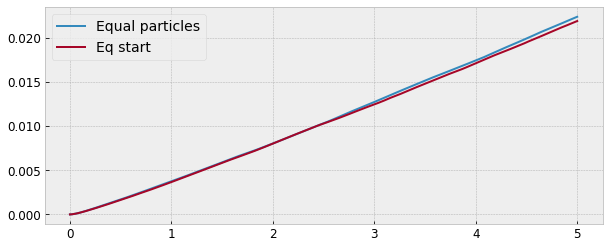

In [43]:
plt.figure()
plt.plot(t, ep_msd, label='Equal particles')
plt.plot(t2, ep_msd_eq_start, label="Eq start")
plt.legend()
plt.show()

In [44]:
s_ep, i_ep, q_ep, gamma_ep = get_q_and_gamma(t, ep_msd, value_start=150, m=1, kT=0.02) 

In [45]:
print(gamma_ep, q_ep, q_ep/gamma_ep, s_ep/4)

16.656082882258296 0.6662433152903319 0.04 0.0012007625166961418


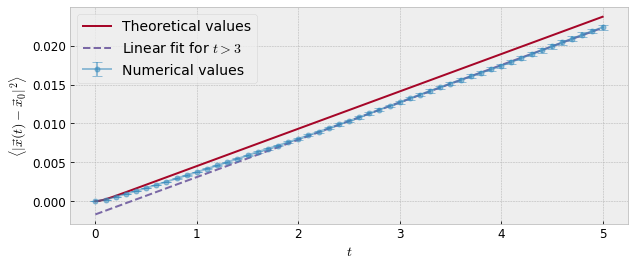

In [46]:
plt.figure()
plt.errorbar(t[::5], ep_msd[::5], yerr=std_ep[::5]/np.sqrt(50), fmt="-o", capsize=5, markersize=5, alpha=0.5, label='Numerical values')
plt.plot(t, msd_function_v0(t, q_ep, gamma_ep), label= 'Theoretical values')
plt.plot(t, i_ep+t*s_ep, '--', label= r'Linear fit for $t>3$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle|\vec{x}(t)-\vec{x}_0|^2\rangle$')
#plt.title(r'Mean square displacement for equal particles')
plt.legend()
plt.savefig(os.path.join(plots_folder, 'msd_eq_particles.pdf'))
plt.show()

In [77]:
s_ep_eq, i_ep_eq, q_ep_eq, gamma_ep_eq = get_q_and_gamma(t2, ep_msd_eq_start, value_start=150, m=1, kT=0.02)

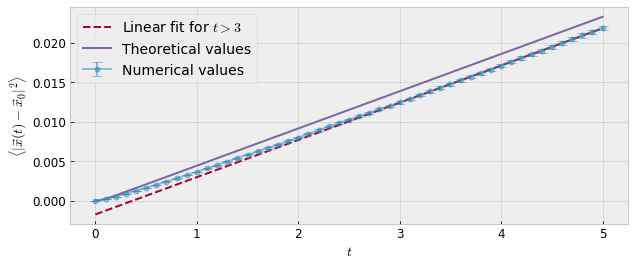

In [95]:
plt.figure()
plt.errorbar(t2[::5], ep_msd_eq_start[::5], yerr=std_ep_eq_start[::5]/np.sqrt(50), fmt="-o", capsize=5, markersize=5, alpha=0.5, label='Numerical values')
plt.plot(t2, i_ep_eq+t*s_ep_eq, '--', label= r'Linear fit for $t>3$')
plt.plot(t2, msd_function_v0(t2, q_ep_eq, gamma_ep_eq), label= 'Theoretical values')
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle|\vec{x}(t)-\vec{x}_0|^2\rangle$')
#plt.title(r'Mean square displacement eq with eq start')
plt.legend()
plt.show()

### Brownian particle with m=3m0 and v = v0/sqrt(3)

In [89]:
t, msd_3m0, msd_3m0_std, ss_3m0, ss_3m0_std = read_and_create_data(runs=400, t_stop=5, timestep=0.02, filenames='diffProperties_r03m0_particle_tmax_5_run_X.npy')

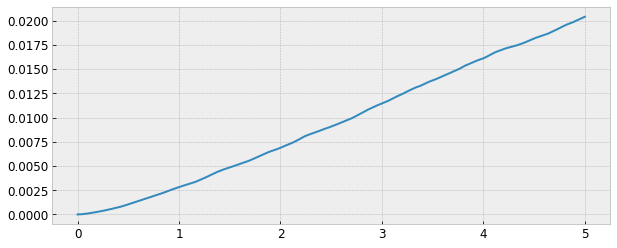

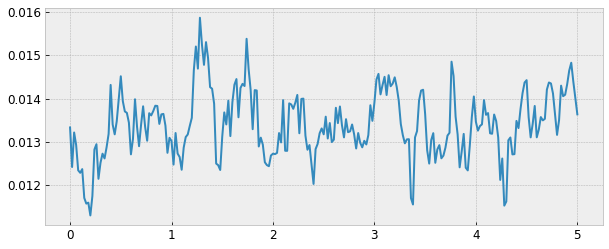

In [96]:
plt.figure()
plt.plot(t, msd_3m0)
plt.figure()
plt.plot(t, ss_3m0)
plt.show()

In [91]:
s, i, q, gamma = get_q_and_gamma(t, msd_3m0, value_start=150, m=3, kT=0.02)

In [92]:
print(gamma, q, q/gamma, s/4)

6.072484449991933 0.08096645933322577 0.013333333333333334 0.001097848289537493


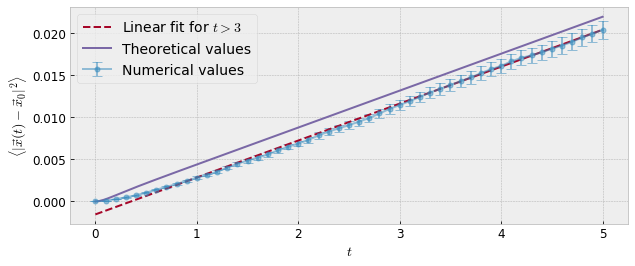

In [97]:
plt.figure()
plt.errorbar(t[::5], msd_3m0[::5], yerr=msd_3m0_std[::5]/np.sqrt(400), fmt="-o", capsize=5, markersize=5, alpha=0.5, label='Numerical values')
plt.plot(t, i+t*s, '--', label= r'Linear fit for $t>3$')
plt.plot(t, msd_function_v0(t, q, gamma), label= 'Theoretical values')
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle|\vec{x}(t)-\vec{x}_0|^2\rangle$')
plt.legend()
plt.show()

### Brownian particle with r=3r0

In [47]:
t, msd_3r0, msd_3r0_std, ss_3r0, ss_3r0_std = read_and_create_data(runs=300, t_stop=5, timestep=0.02, filenames='diffProperties_3r0m0_particle_tmax_5_run_X.npy')

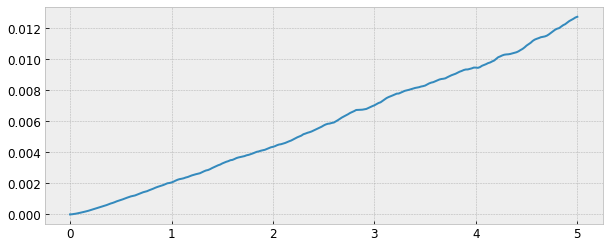

In [48]:
plt.figure()
plt.plot(t, msd_3r0)
plt.show()

In [61]:
msd_3r0 = msd_3r0[:200]
t = t[:200]
msd_3r0_std = msd_3r0_std[:200]

In [62]:
s, i, q, gamma = get_q_and_gamma(t, msd_3r0, value_start=150, m=1, kT=0.02)

In [63]:
print(gamma, q, q/gamma, s/4)

33.74725980624537 1.3498903922498147 0.04 0.000592640709640631


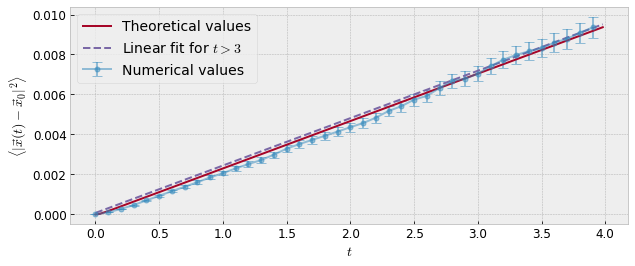

In [65]:
plt.figure()
plt.errorbar(t[::5], msd_3r0[::5], yerr=msd_3r0_std[::5]/np.sqrt(300), fmt="-o", capsize=5, markersize=5, alpha=0.5, label='Numerical values')
plt.plot(t, msd_function_v0(t, q, gamma), label= 'Theoretical values')
plt.plot(t, i+t*s, '--', label= r'Linear fit for $t>3$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle|\vec{x}(t)-\vec{x}_0|^2\rangle$')
plt.legend()
plt.savefig(os.path.join(plots_folder, 'msd_3r0.pdf'))
plt.show()

### Brownian particle with m = 3m0 and v = v0

In [121]:
t, msd_3m0_eq_speed, msd_3m0_eq_speed_std, ss_3m0_eq_speed, ss_3m0_eq_speed_std = read_and_create_data(runs=300, t_stop=5, timestep=0.02, filenames='diffProperties_r03m0_particle_tmax_5_run_X_eq_speed.npy')

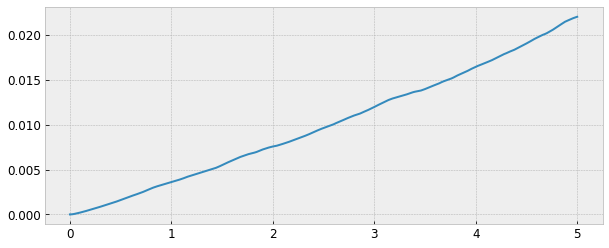

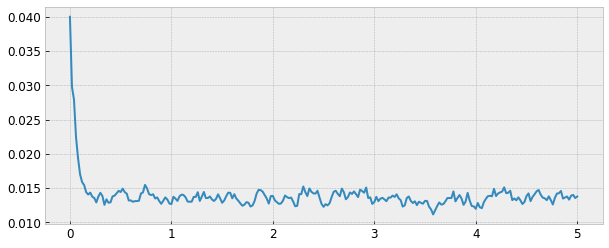

In [122]:
plt.figure()
plt.plot(t, msd_3m0_eq_speed)
plt.figure()
plt.plot(t, ss_3m0_eq_speed)
plt.show()

In [125]:
s, i, q, gamma = get_q_and_gamma(t, msd_3m0_eq_speed, value_start=150, m=3, kT=0.02002)

In [133]:
print(gamma, q, q/gamma, s/4, ss_3m0_eq_speed[-1])

5.333641939818482 0.07118634109011067 0.013346666666666666 0.001251177602214603 0.013771329823347889


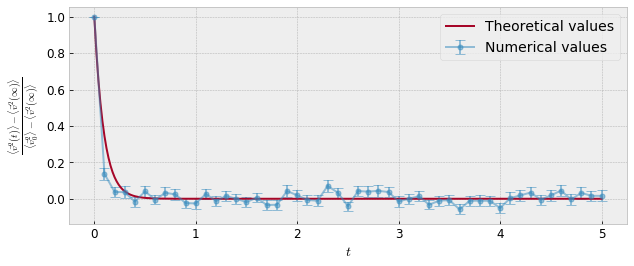

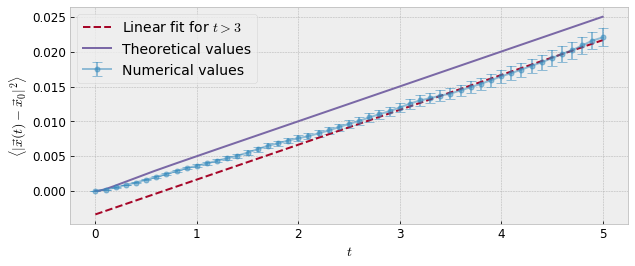

In [135]:
plt.figure()
plt.errorbar(t[::5], (ss_3m0_eq_speed[::5]-q/gamma)/(0.04-q/gamma), yerr=ss_3m0_eq_speed_std[::5]/(np.sqrt(300)*(0.04-q/gamma)), fmt="-o", capsize=5, markersize=5, alpha=0.5, label='Numerical values')
plt.plot(t, np.exp(-2*gamma*t), label="Theoretical values")
plt.xlabel(r'$t$')
plt.ylabel(r'$\frac{\langle\vec{v}^2(t)\rangle-\langle\vec{v}^2(\infty)\rangle}{\langle\vec{v}_0^2\rangle-\langle\vec{v}^2(\infty)\rangle}$')
plt.legend()
plt.figure()
plt.errorbar(t[::5], msd_3m0_eq_speed[::5], yerr=msd_3m0_eq_speed_std[::5]/np.sqrt(300), fmt="-o", capsize=5, markersize=5, alpha=0.5, label='Numerical values')
plt.plot(t, i+t*s, '--', label= r'Linear fit for $t>3$')
plt.plot(t, msd_function_v0(t, q, gamma), label= 'Theoretical values')
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle|\vec{x}(t)-\vec{x}_0|^2\rangle$')
plt.legend()
plt.show()

### Brownian particle m=10m0, v = v0

In [67]:
t, msd_10m0, msd_10m0_std, ss_10m0, ss_10m0_std = read_and_create_data(runs=300, t_stop=5, timestep=0.02, filenames='diffProperties_r010m0_particle_tmax_5_run_X_eq_speed.npy')

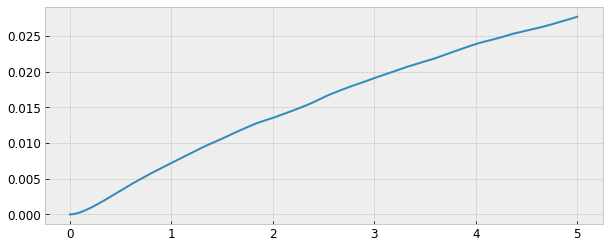

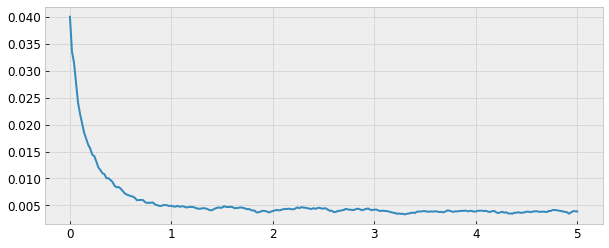

In [68]:
plt.figure()
plt.plot(t, msd_10m0)
plt.figure()
plt.plot(t, ss_10m0)
plt.show()

In [69]:
s, i, q, gamma = get_q_and_gamma(t, msd_10m0, value_start=175, m=10, kT=0.02009)

In [70]:
print(gamma, q, q/gamma, s/4, ss_10m0[-1])

1.980007538133981 0.007955670288222336 0.004018000000000001 0.0010146426017616794 0.00388299007177146


In [71]:
popt = adjust_curve(t, msd_10m0, msd_function_v0)

In [72]:
popt

array([0.0151483 , 2.45905049])

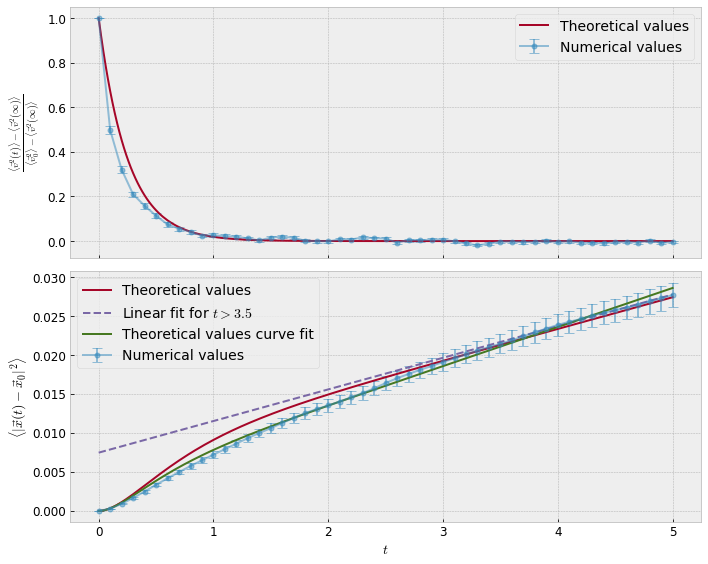

In [74]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))
axes[0].errorbar(t[::5], (ss_10m0[::5]-q/gamma)/(0.04-q/gamma), yerr=ss_10m0_std[::5]/(np.sqrt(300)*(0.04-q/gamma)), fmt="-o", capsize=5, markersize=5, alpha=0.5, label='Numerical values')
axes[0].plot(t, np.exp(-2*gamma*t), label="Theoretical values")
#axes[0].set_xlabel(r'$t$')
axes[0].set_ylabel(r'$\frac{\langle\vec{v}^2(t)\rangle-\langle\vec{v}^2(\infty)\rangle}{\langle\vec{v}_0^2\rangle-\langle\vec{v}^2(\infty)\rangle}$')
axes[0].legend()
axes[1].errorbar(t[::5], msd_10m0[::5], yerr=msd_10m0[::5]/np.sqrt(300), fmt="-o", capsize=5, markersize=5, alpha=0.5, label='Numerical values')
axes[1].plot(t, msd_function_v0(t, q, gamma), label= 'Theoretical values')
axes[1].plot(t, i+t*s, '--', label= r'Linear fit for $t>3.5$')
axes[1].plot(t, msd_function_v0(t, *popt), label='Theoretical values curve fit')
axes[1].set_xlabel(r'$t$')
axes[1].set_ylabel(r'$\langle|\vec{x}(t)-\vec{x}_0|^2\rangle$')
axes[1].legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_folder, 'msd_ss_10m0.pdf'))
plt.show()